<a href="https://colab.research.google.com/github/Huy1ee04/VRPTW_potvin/blob/main/VRPTW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The vehicle routing problem with Time Windows (VRPTW)**

###**The approach:** A parallel route building algorithm for the vehicle routing and scheduling problem with time windows

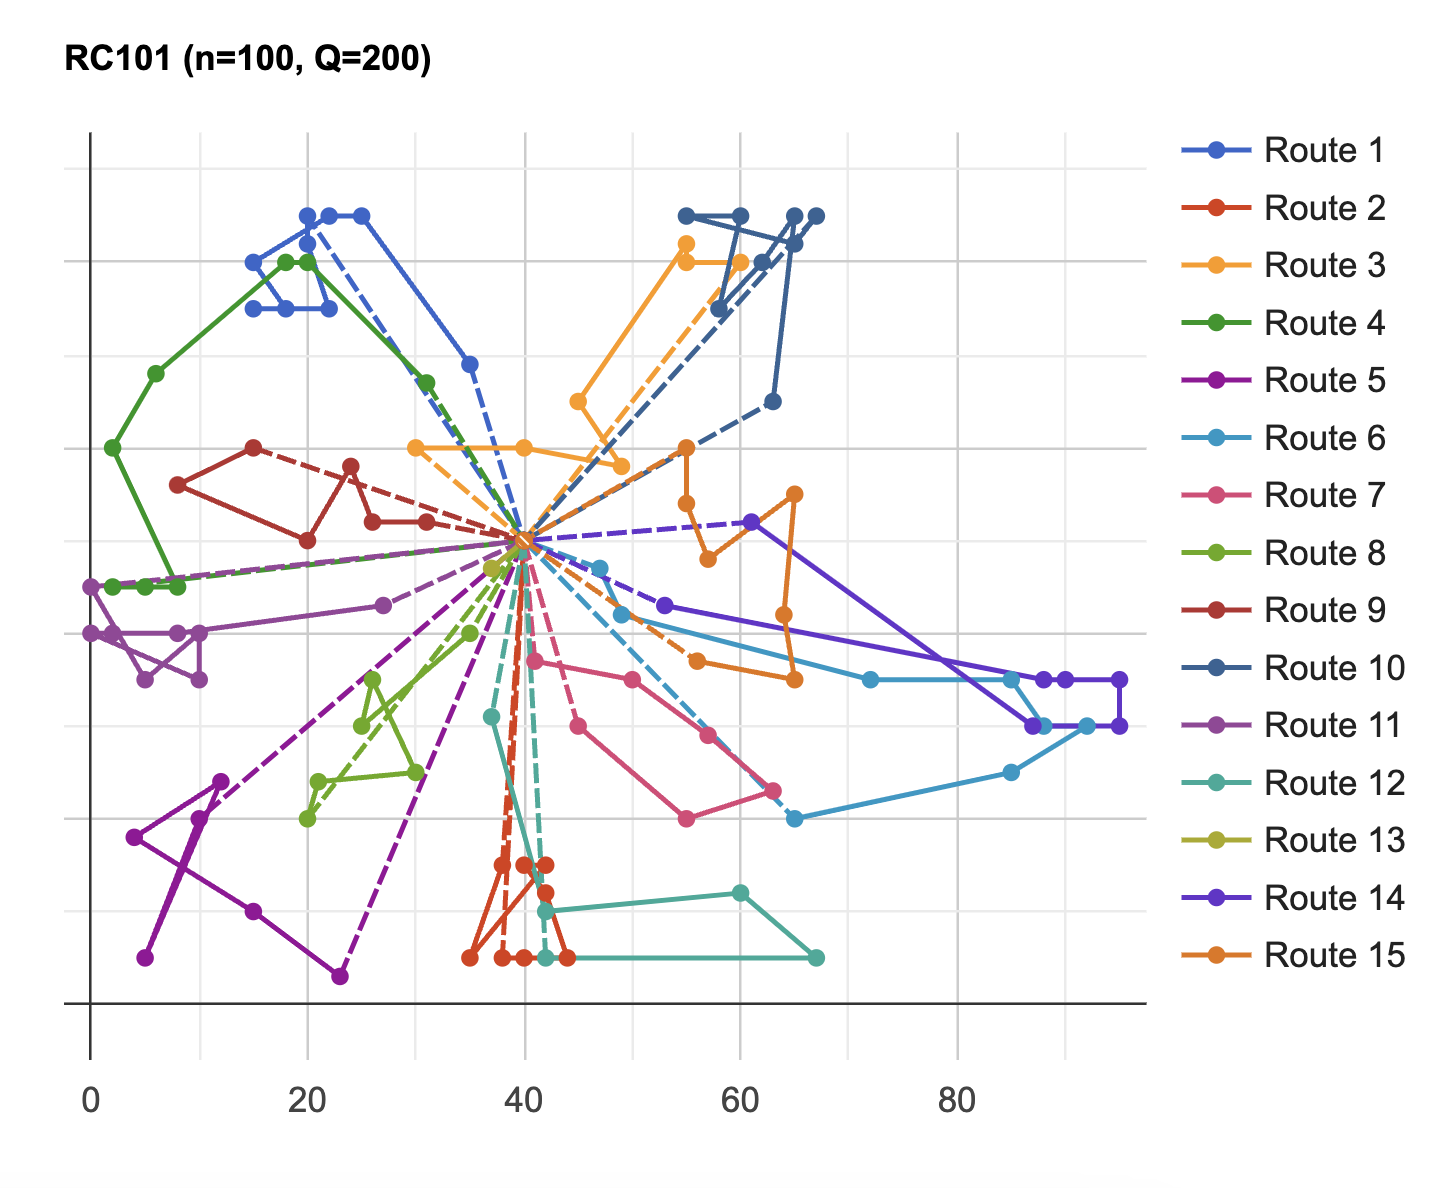



In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Read data**

In [66]:
import pandas as pd
import numpy as np

# Read file
file_path = "/content/drive/MyDrive/VRPTW_data/RC102.txt"
with open(file_path, 'r') as file:
    lines = file.readlines()

# Fetch capacity
capacity = None
for i, line in enumerate(lines):
    if "CAPACITY" in line:
        capacity = int(lines[i+1].split()[1])
        break

# Fetch customer data
customer_data = lines[7:]
columns = ["CUST NO.", "XCOORD.", "YCOORD.", "DEMAND", "READY TIME", "DUE DATE", "SERVICE TIME"]

# Filter & change to dataframe
customer_info = []
for line in customer_data:
    if line.strip() and line.split()[0].isdigit():
        customer_info.append([int(x) for x in line.split()])

df = pd.DataFrame(customer_info, columns=columns)
df.set_index("CUST NO.", inplace=True)
# Fetch depot (is record 0)
depot = (df.index[0], (df.iloc[0]["XCOORD."], df.iloc[0]["YCOORD."]))
#customers list
customers = [(index, (row["XCOORD."], row["YCOORD."])) for index, row in df.iloc[1:].iterrows()]
#service_times list
service_times = df["SERVICE TIME"].iloc[0:].to_dict()
#time_windows list
time_windows = {
    index: (row["READY TIME"], row["DUE DATE"])
    for index, row in df.iloc[0:].iterrows()
}

#Test
print("Capacity:", capacity)
print(df.head())
print("Depot:", depot)
print("Customers:", customers)
print("ServiceTimes:",service_times)
print("Time Windows:", time_windows)



Capacity: 200
          XCOORD.  YCOORD.  DEMAND  READY TIME  DUE DATE  SERVICE TIME
CUST NO.                                                              
0              40       50       0           0       240             0
1              25       85      20           0       191            10
2              22       75      30           0       199            10
3              22       85      10           0       190            10
4              20       80      40         141       171            10
Depot: (0, (40, 50))
Customers: [(1, (25, 85)), (2, (22, 75)), (3, (22, 85)), (4, (20, 80)), (5, (20, 85)), (6, (18, 75)), (7, (15, 75)), (8, (15, 80)), (9, (10, 35)), (10, (10, 40)), (11, (8, 40)), (12, (8, 45)), (13, (5, 35)), (14, (5, 45)), (15, (2, 40)), (16, (0, 40)), (17, (0, 45)), (18, (44, 5)), (19, (42, 10)), (20, (42, 15)), (21, (40, 5)), (22, (40, 15)), (23, (38, 5)), (24, (38, 15)), (25, (35, 5)), (26, (95, 30)), (27, (95, 35)), (28, (92, 30)), (29, (90, 35)), (30, (88, 30

#**Parameters**

In [67]:
max_cost = float('inf')
"""
    Reference parameters from Solomon's article:
alpha1 = 1
alpha2 = 0
lambda_para = {1,2}
mu = 1
"""
"""
Notice:
    customers, depot : (int,(double,double)) // (id,coordinate)
    route[No.] : [(int,(double,double))] // list customer
    n_r : int
    service_times[customer_id] : double
    time_windows[customer_id] : (double,double)
    max_cost : double
    S_seed : list of customers
"""

'\nNotice:\n    customers, depot : (int,(double,double)) // (id,coordinate)\n    route[No.] : [(int,(double,double))] // list customer\n    n_r : int\n    service_times[customer_id] : double\n    time_windows[customer_id] : (double,double)\n    max_cost : double\n    S_seed : list of customers\n'

#**Functions: Calculate distance, Check time feasibility, Find best position to insert customer, Calculate total cost**
##   Convention: 1 unit of distance is equal to 1 unit of service time

In [68]:
def distance(p1, p2):
    """Calculate Euclidean distance between two points."""
    return ((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2) ** 0.5

#Update new service time if additional customers are inserted
def bj_new(current_time, prev_customer, next_customer, new_customer):
    """Calculate the new time when service at next customer begins, given the insertion of new customer."""
    travel_time_prev_to_new = distance(prev_customer[1], new_customer[1])
    travel_time_new_to_next = distance(new_customer[1], next_customer[1])
    return max(time_windows[next_customer[0]][0], max(time_windows[new_customer[0]][0], current_time + travel_time_prev_to_new) + service_times[new_customer[0]] + travel_time_new_to_next)

#push forward (PF)
def check_time_feasibility(route, new_customer, position):
    """
      position : (route[i], route[i+1])
    """
    """Check if inserting a customer at a specific position violates time windows."""
    current_time = 0  # current_time : the time when the service at route[i] begins
    push_forward = -1 # Define push forward
    for i in range(0, len(route)-1):
        current_time += service_times[route[i][0]]
        travel_time = distance(route[i][1], route[i+1][1])
        wait_time = max(0, time_windows[route[i+1][0]][0] - current_time - travel_time)
        if push_forward > 0 : push_forward = max(0, push_forward - wait_time)
        if push_forward == 0 :
            return True  # Check push_forward
        if route[i] == position[0]: # Insert position
            # Add travel time and service time for the new customer
            b_i = current_time
            b_j = max(time_windows[route[i+1][0]][0], b_i + distance(route[i][1], route[i+1][1]))
            current_time = max(time_windows[new_customer[0]][0], current_time + distance(route[i][1], new_customer[1]))
            if current_time > time_windows[new_customer[0]][1]:  # Check end of time window of new customer
                return False
            current_time = bj_new(current_time, route[i], route[i+1], new_customer)
            push_forward = bj_new(current_time, route[i], route[i+1], new_customer) - b_j
        else:
            current_time = max(time_windows[route[i+1][0]][0], current_time + travel_time)
        if current_time > time_windows[route[i+1][0]][1]:  # Check end of time window
            return False
    return True

#Find C1_optimize
def insertion_cost(route, customer, alpha1, alpha2):
    """Calculate the insertion cost of a customer in a route."""
    min_cost = max_cost
    best_position = None
    for i in range(len(route) - 1):
        i_r, j_r = route[i], route[i + 1]
        # Distance-based cost
        dist_cost = distance(i_r[1], customer[1]) + distance(customer[1], j_r[1]) - distance(i_r[1], j_r[1]) # c11
        # Time-based cost
        time_cost = bj_new(0, i_r, j_r, customer) - max(time_windows[j_r[0]][0], distance(i_r[1], j_r[1]))  # c12
        # Weighted cost
        cost = alpha1 * dist_cost + alpha2 * time_cost  # c1
        if cost < min_cost and check_time_feasibility(route, customer, (i_r, j_r)):
            min_cost = cost
            best_position = (i_r, j_r)
    return min_cost, best_position

def calculate_cost(routes):
    """Calculate the total cost of a set of routes."""
    if routes is not None:
      cost = 0
      for route in routes:
          for i in range(0, len(route)-1):
              cost += distance(route[i][1], route[i+1][1])
      return cost
    return max_cost #inf

#**Procedure Build-routes(n_r, α1​, α2, S_{seed,n_r})**

In [69]:
def build_routes(nr, alpha1, alpha2, S_seed):
    """
    Build routes with service times and time windows, ensuring no time conflicts.

    Args:
        n_r: Number of initial routes.
        alpha1: Weight parameter for distance-based cost.
        alpha2: Weight parameter for time-based cost.
        S_seed: Initial set of seed customers (one per route).
        customers: List of all customers to route (each customer has coordinates and time window).
        depot: Coordinates or location of the depot.
        service_times: List of service times for each customer.
        time_windows: List of time windows (start, end) for each customer.
        max_cost: A large value for infeasible insertions.

    Returns:
        Solution routes if feasible; otherwise, None.
    """
    # Initialize routes with seed customers
    routes = [[depot, seed, depot] for seed in S_seed]
    unrouted_customers = [c for c in customers if c not in S_seed]

    while unrouted_customers:
        # Step 1: Calculate insertion costs for all unrouted customers
        c2u_list = []
        for customer in unrouted_customers:
            c1r_star = []
            for route in routes:
                cost, best_position = insertion_cost(route, customer, alpha1, alpha2)
                c1r_star.append((customer, cost, best_position, route))

            # Sort c1r_star and find the best route (r')
            c1r_star.sort(key=lambda x: x[1])
            min_cost = c1r_star[0][1]

            # Compute c2(u)
            c2u_list.append((c1r_star[0], sum(c1r[1] - min_cost for c1r in c1r_star[1:])))
        # Step 2: Select the customer with the maximum regret cost
        u_star_tuple = max(c2u_list, key=lambda x: x[1])[0]  # Keep the full tuple
        (u_star, best_cost, best_position, best_route) = u_star_tuple
        if best_cost == max_cost:
            return None # Not return a solution

        # Step 3: Insert the customer into the best route
        if best_cost < max_cost and best_route is not None and best_position is not None:
          i_r, j_r = best_position
          index = best_route.index(i_r)
          best_route.insert(index + 1, u_star)
          unrouted_customers.remove(u_star)
        else:
          # Return NIL if no feasible insertion is found
          return None

    return routes


# **Step 0: Estimate the initial number of routes and the initial set of seed customers**
##Using Solomon's sequential algorithm (I1) with the parameter setting (β, α1​, α2) = (1,1,0); λ = k = 1
##Convention: β = 1 means chosing the farthest customer to be the first seed


In [70]:
# Solomon's sequential algorithm
farthest_customer = max(customers, key = lambda x : distance(x[1], depot[1]))
routes = [[depot, farthest_customer, depot]]
current_route = 0
unrouted_customers = [c for c in customers if c not in [farthest_customer, depot]]

# c2
def c2_u(k, insert_customer):
  return k*distance(insert_customer[0][1], depot[1]) - insert_customer[1][0] #  lambda*d_0_u - c1


while unrouted_customers:
  c1_list = []
  for i in unrouted_customers:
    c1_list.append((i, insertion_cost(routes[current_route], i, 1, 0))) # (customer, (min_cost, best_position))

  #Get best customer based on c1_min and c2_max
  best_customer, (min_cost, best_position) = max(c1_list, key = lambda x : c2_u(1, x)) # Find customer with biggest c2
  if min_cost == max_cost:
    current_route += 1
    farthest_customer = max(unrouted_customers, key = lambda x : distance(x[1], depot[1]))
    routes.append([depot, farthest_customer, depot])
    unrouted_customers.remove(farthest_customer)
  else:
    index = routes[current_route].index(best_position[0])
    routes[current_route].insert(index + 1, best_customer)
    unrouted_customers.remove(best_customer)

# Estimate the initial number of routes nr and the initial set of seed customers S_seed_nr based on I1 argorithm
nr = len(routes)
S_seed_nr = [max(route, key = lambda x : distance(x[1], depot[1])) for route in routes]
# Test
print(nr)
print(S_seed_nr)
print(calculate_cost(routes))

16
[(26, (95, 30)), (75, (5, 5)), (89, (67, 5)), (29, (90, 35)), (33, (85, 25)), (77, (23, 3)), (35, (67, 85)), (16, (0, 40)), (5, (20, 85)), (19, (42, 10)), (73, (2, 60)), (74, (20, 20)), (44, (55, 82)), (11, (8, 40)), (62, (65, 35)), (88, (24, 58))]
1822.146904078365


#**Using Matplotlib to visualize result**

<ipython-input-71-8a196c3b8213>:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab20", len(routes))


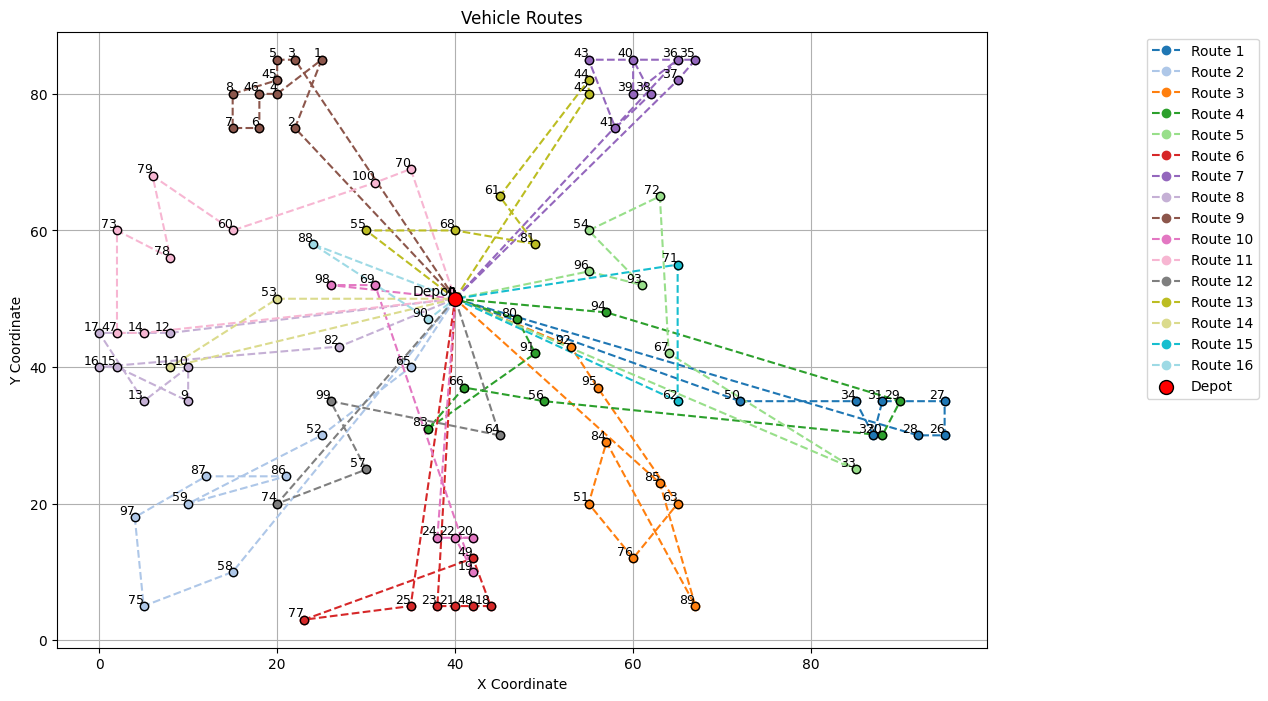

In [71]:
import matplotlib.pyplot as plt
import numpy as np

def plot_routes_with_ids(routes, depot):
    """
    Plot the routes from the depot to the customers. Each route is in the format (customer_id, (x, y)).

    Args:
        routes (list): List of routes.
                       Each route is a list of points (customer_id, (x, y)).
        depot (tuple): Coordinates of the depot (x, y).
    """
    # Create different colors for each route
    colors = plt.cm.get_cmap("tab20", len(routes))

    plt.figure(figsize=(12, 8))

    # Plot each route
    for i, route in enumerate(routes):
        # Extract coordinates from the route
        coordinates = [coord for _, coord in route]
        # Add the depot to the start and end of the route
        full_route = [depot] + coordinates + [depot]
        x_coords, y_coords = zip(*full_route)

        # Plot the route with a dashed line
        plt.plot(x_coords, y_coords, linestyle='--', marker='o', color=colors(i), label=f"Route {i + 1}")

        # Mark each customer with their customer_id
        for customer_id, (x, y) in route:
            plt.scatter(x, y, color=colors(i), edgecolor='black', zorder=5)
            plt.text(x, y, str(customer_id), fontsize=9, ha='right', va='bottom')

    # Mark the depot
    plt.scatter(*depot, color='red', edgecolor='black', s=100, label='Depot', zorder=6)
    plt.text(depot[0], depot[1], "Depot", fontsize=10, ha='right', va='bottom')

    # Customize axes and legend
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Vehicle Routes')
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    plt.grid()
    plt.show()

# Test
plot_routes_with_ids(routes, depot[1])


# **Manipulate**

In [72]:
def remove_closest_seed(S_seed):
    """
    Removes the customer 's*' that is closest to the other customers in S_seed.
    """
    if len(S_seed) <= 1:
        return S_seed
    # Calculate the total distance between each customer and all others
    min_distance = []
    for s in S_seed:
      min_cost = max_cost
      for s_i in S_seed:
        if s != s_i: min_cost = min(min_cost, distance(s[1], s_i[1]))
      min_distance.append((s, min_cost))
    min_distance.sort(key=lambda x: x[1])
    s_star = min_distance[0][0]
    # Remove the closest customer from S_seed
    S_seed.remove(s_star)
    print("Remove s_star:",s_star)
    return S_seed

parameter_values = [(0.5, 0.5), (0.75, 0.25), (1.0, 0.0)]
S_a1_a2 = {}
best_solution = None
S_a1_a2 = {n_r: [(0.5, 0.5), (0.75, 0.25), (1.0, 0.0)] for n_r in range(nr+1)}

print(S_a1_a2)

def recursive_algorithm(nr, S_seed_nr_before, S_seed_nr):
    global best_solution
    print("Now nr =", nr)
    """
    Recursive implementation of the algorithm.

    Args:
        S_alpha_nr (list): Set of parameter settings [(a1, a2), ...].
        n_r (int): Current number of routes.
        S_seed_nr (list): Current seed set for n_r.
        n_r_min (int): Minimum number of routes found.
        best_solution: Best solution found so far.
    Returns:
        tuple: (n_r_min, best_solution)
    """

    # Step 2: Select and remove a parameter setting (a1, a2)
    a1, a2 = S_a1_a2[nr].pop(0)
    print("Remove:", (a1,a2))

    # Step 3: Call Build-routes(nr, a1, a2, S_seed_nr)
    if build_routes(nr, a1, a2, S_seed_nr):
        # Step 4: Build-routes returns a solution
        best_solution = build_routes(nr, a1, a2, S_seed_nr) # Remember the solution
        print("Best solution:",best_solution)
        print("Best cost:", calculate_cost(best_solution))
        nr -= 1
        print("Build routes successful!")
        # Update S_seed_nr by removing the minimum distance
        S_seed_nr_new = remove_closest_seed(S_seed_nr.copy())
        print(" ")
        # Recurse with updated values
        return recursive_algorithm(nr, S_seed_nr, S_seed_nr_new)
    else:
        print(" ")
        # No solution was found
        if not S_a1_a2[nr]:
            nr = nr + 1
            return nr, S_seed_nr_before
        else:
            # Recurse with the remaining parameters
            return recursive_algorithm(nr, S_seed_nr_before, S_seed_nr)

# Run the algorithm
nr_min, S_seed_nr_min = recursive_algorithm(nr, S_seed_nr, S_seed_nr)
print("nr_min:", nr_min)
if len(S_a1_a2[nr])>0:
  a1, a2 = S_a1_a2[nr_min].pop(0)
  print("Remove:", (a1,a2))
  if build_routes(nr_min, a1, a2, S_seed_nr_min):
    if calculate_cost(best_solution) > calculate_cost(build_routes(nr_min, a1, a2, S_seed_nr_min)):
      best_solution = build_routes(nr_min, a1, a2, S_seed_nr_min)

print("Best solution is: ", best_solution)
print("Best cost:", calculate_cost(best_solution))


{0: [(0.5, 0.5), (0.75, 0.25), (1.0, 0.0)], 1: [(0.5, 0.5), (0.75, 0.25), (1.0, 0.0)], 2: [(0.5, 0.5), (0.75, 0.25), (1.0, 0.0)], 3: [(0.5, 0.5), (0.75, 0.25), (1.0, 0.0)], 4: [(0.5, 0.5), (0.75, 0.25), (1.0, 0.0)], 5: [(0.5, 0.5), (0.75, 0.25), (1.0, 0.0)], 6: [(0.5, 0.5), (0.75, 0.25), (1.0, 0.0)], 7: [(0.5, 0.5), (0.75, 0.25), (1.0, 0.0)], 8: [(0.5, 0.5), (0.75, 0.25), (1.0, 0.0)], 9: [(0.5, 0.5), (0.75, 0.25), (1.0, 0.0)], 10: [(0.5, 0.5), (0.75, 0.25), (1.0, 0.0)], 11: [(0.5, 0.5), (0.75, 0.25), (1.0, 0.0)], 12: [(0.5, 0.5), (0.75, 0.25), (1.0, 0.0)], 13: [(0.5, 0.5), (0.75, 0.25), (1.0, 0.0)], 14: [(0.5, 0.5), (0.75, 0.25), (1.0, 0.0)], 15: [(0.5, 0.5), (0.75, 0.25), (1.0, 0.0)], 16: [(0.5, 0.5), (0.75, 0.25), (1.0, 0.0)]}
Now nr = 16
Remove: (0.5, 0.5)
 
Now nr = 16
Remove: (0.75, 0.25)
 
Now nr = 16
Remove: (1.0, 0.0)
 
nr_min: 17
Best solution is:  None
Best cost: inf
